# Calibration of the 4 models using CALL OPTIONS
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')
import time

from MERTONpricer import Merton_pricer
from BSpricer import BS_Pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

random.seed(120)

Let's start retrieving historical prices for **european call** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. The options that will be used in this notebook are all Out-Of-The-Money (OTM) options.

In [2]:
df_call = pd.read_csv('../../data/NVDA/OPT16_NVDA_CALLS_75_135.csv')
print(f'NUM OF CALL OPTS: {df_call.shape[0]}')
print(df_call)

NUM OF CALL OPTS: 5
   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  C_BID  C_ASK  STRIKE     C_IV   
0  2016-01-20            27.47  2017-01-20   7.15   7.40    22.0  0.42468  \
1  2016-01-20            27.47  2017-01-20   5.30   5.45    25.0  0.40081   
2  2016-01-20            27.47  2017-01-20   4.25   4.40    27.0  0.38941   
3  2016-01-20            27.47  2017-01-20   2.98   3.10    30.0  0.37618   
4  2016-01-20            27.47  2017-01-20   1.60   1.68    35.0  0.36536   

   MONEYNESS  
0       0.80  
1       0.91  
2       0.98  
3       1.09  
4       1.27  


The dataframes **df_calls** contains 373 options sorted by their strike price. For our purpose, using the $20\%$ of this DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframe adding **Midpoint** and **Spread** columns.

In [3]:
calls = df_call.sample(frac=1, replace=False).sort_index().reset_index(drop=True)
calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']

q = 0           # dividend yield
r = 0.03        # risk-free interest rate
sigma = 0.3     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
call_strikes = calls['STRIKE']    # array of K for call options
exercise = 'european'

call_prices = calls['C_Midpoint']

The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. These parameters serve only as initialization. Best fitting parameetrs will be calibrated consequently and used to correctly price the options according to each model.

In [4]:
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=0.15, lambd=0.5, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.6, eta1=12, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.3, exercise=exercise)

## Implied volatility
The function belows implements $3$ methods to comcalle implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [5]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if disp:
        return -1

The following code snippet computes the implied volatility of **call** options market prices and show a plot of the implied volatilities found by inversion method against the ones provided by the dataframe.

Implied volatilities of market prices (calls):
S0 = 27.47
K = 22.0, IV = 0.4276
K = 25.0, IV = 0.4013
K = 27.0, IV = 0.3895
K = 30.0, IV = 0.3753
K = 35.0, IV = 0.3637


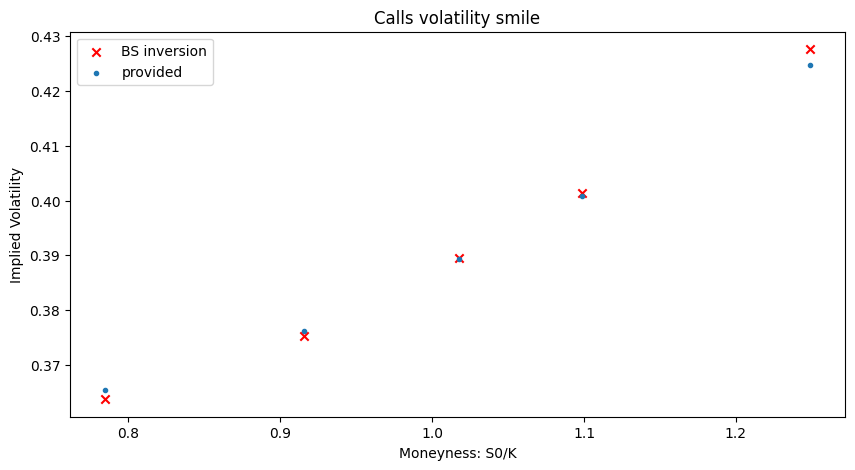

In [12]:
IV_market = []
for i in range(len(call_prices)):
    IV_market.append(implied_volatility(call_prices[i], S=S0, strike=call_strikes[i], t = T, rate=0.02, q = 0.022, type_o='call', method='fsolve'))

print(f'Implied volatilities of market prices (calls):\nS0 = {S0}')
for a,b in zip(call_strikes.tail(6), IV_market[-6:]):
    print(f'K = {a}, IV = {round(b, 4)}')

# Plot market implied volatilities w.r.t. log moneyness
x = (S0/call_strikes)
IV_filtered = [iv for iv in IV_market if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market, x) if iv != -1]

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(x, IV_market, marker='x', label='BS inversion', color='red')
ax1.scatter(x, calls['C_IV'], marker='.', label='provided')
ax1.set_xlabel('Moneyness: S0/K'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('Calls volatility smile')
ax1.legend(); plt.show()


##  Weighted Calibration (call options)
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i },$$ $P_i$ are the market prices and $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perform this optimization problem, many numerical methods can be used. In particular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works with bounds. The default algorithm is [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region). The [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) has been tried as well, to test the optimization problem without setting boundaries, but the results don't make any sense.
2. **Least-Squares**, a constrained minimization problem which uses Trust region reflective method by default. This method is the most indicated to solve the non-linear least squares optimization problem of our purpose.
All the optimizations are carried out by initializing a starting point as the array $x_0 = [params]$ and setting feasible bounds.


In [13]:
call_spreads = calls['C_Spread']
c_weights = 1/ call_spreads**2

### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of call options.

In [14]:
x0 = 0.5
bounds = [1e-5, 2]

def f_BlackScholes_calls(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise=exercise)
    return BS.closed_formula_call(x)

res1_calls = scpo.curve_fit(f_BlackScholes_calls, call_strikes, call_prices, p0 = x0, bounds=bounds, sigma=c_weights)
sigw_p = round(res1_calls[0][0],4)

In [15]:
def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise=exercise)
    sq_err = np.sum(c_weights* (BS.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

result_p = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=1)
opt_sigma_p = result_p.x[0]

`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 4.1083e+05, final cost 7.6646e-02, first-order optimality 3.26e-04.


In [16]:
print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')
print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {opt_sigma_p} \t {round(opt_sigma_p*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.3469 	 34.69%
METHOD 2: LEAST-SQUARES (trf)
> Calibrated Volatility from Calls [σ] = 0.33965799150370934 	 33.97%


### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [17]:
x0 = [0.15,  0.2, -0.05,  0.01]  # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -5, 1e-5], [2, 5, 5, 2] )

In [18]:
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)

start1=time.time()
mert1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=call_spreads)
end1=time.time()

mert_params1 = [round(p,4) for p in mert1[0][:4]]

##### Method 2. Least-squares

In [19]:
x0 = [0.15,  0.5, -0.05,  0.1]      # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -10, 0], [2, np.inf, 10, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum(c_weights*(M.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

start2 = time.time()
mert2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=2)
end2 = time.time()

mert_params2 = [round(p,4) for p in mert2.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4303e+05                                    1.11e+07    
       1              2         8.5442e+01      3.43e+05       5.66e-01       1.73e+04    
       2              7         7.2931e+01      1.25e+01       1.21e-02       6.70e+03    
       3              8         6.2209e+01      1.07e+01       5.92e-03       1.40e+04    
       4              9         5.2917e+01      9.29e+00       1.23e-02       5.39e+03    
       5             10         4.5469e+01      7.45e+00       6.04e-03       1.22e+04    
       6             11         3.8535e+01      6.93e+00       1.26e-02       4.35e+03    
       7             12         3.3384e+01      5.15e+00       6.14e-03       1.05e+04    
       8             13         2.8044e+01      5.34e+00       1.27e-02       3.49e+03    
       9             14         2.4511e+01      3.53e+00       6.18e-03       8.86e+03    

In [20]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(mert1[0][0],4)} \t {round(mert1[0][0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert1[0][1],2))
print('> Calibrated Jump Mean = ', round(mert1[0][2],2))
print('> Calibrated Jump St. dev.  = ', round(mert1[0][3],5))
print(f'ELAPSED TIME: {end1-start1} sec')

print('\nMETHOD 1: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params2[0]} \t {round(mert_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params2[1],2))
print('> Calibrated Jump Mean = ', round(mert_params2[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params2[3],3))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.1643 	 16.43%
> Calibrated Jump intensity [λ] =  5.0
> Calibrated Jump Mean =  -0.03
> Calibrated Jump St. dev.  =  0.13491
ELAPSED TIME: 41.826136112213135 sec

METHOD 1: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.2567 	 25.67%
> Calibrated Jump intensity [λ] =  1.01
> Calibrated Jump Mean =  -0.078
> Calibrated Jump St. dev.  =  0.233
TIME ELAPSED:  66.16 sec


In [21]:
print(mert_params1)
print(mert_params2)

[0.1643, 5.0, -0.0333, 0.1349]
[0.2567, 1.0107, -0.078, 0.2328]


### Kou Jump Diffusion


In [22]:
x0 = [0.2, 0.7, 0.5, 8, 10] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-2, 1e-1, 0, 0.5, 0.5], [0.5, 4, 1, 15, 20] )

##### Method 1. TRF (Bounds)

In [23]:
# def f_Kou(x, sigma, lambd, p, eta1, eta2):
#     KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
#     return KouJD.closed_formula_call(x)
#
# start1 = time.time()
# kou1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=c_weights)
# end1 = time.time()
#
# kou_params1 = [round(p,4) for p in kou1[0][:5]]

##### Method 2. LEAST SQUARES (With Bounds)

In [24]:
# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(c_weights*(KOU.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=2)
end2=time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5359e+04                                    4.35e+05    
       1              2         4.3792e+03      4.10e+04       6.24e-02       6.96e+04    
       2              3         3.8861e+02      3.99e+03       3.34e-02       1.04e+04    
       3              4         3.2140e+01      3.56e+02       1.86e-02       1.45e+03    
       4              5         2.8943e+00      2.92e+01       1.06e-02       1.90e+02    
       5              6         5.1560e-01      2.38e+00       7.02e-03       1.47e+01    
       6              9         4.7394e-01      4.17e-02       8.83e-04       5.80e+00    
       7             10         4.6661e-01      7.33e-03       8.38e-04       3.54e+00    
       8             12         4.6490e-01      1.71e-03       3.22e-04       2.55e+00    
       9             13         4.6389e-01      1.01e-03       5.99e-04       2.55e+00    

In [25]:
kou_params2 = [round(p,4) for p in kou2.x[:5]]

In [26]:
# print('WEIGHTED OPT: CURVE_FIT (trf)')
# print(f'> Calibrated Volatlity [σ] = {kou_params1[0]} \t {kou_params1[0] * 100}%')
# print('> Calibrated Jump intensity [λ] = ', kou_params1[1])
# print(f'> Calibrated Upward Jump probability [p] = {kou_params1[2]}, [q] = {round(1 - kou_params1[2], 2)}')
# print('> Calibrated Rate of Exp. 1  [η_1] = ', kou_params1[3])
# print('> Calibrated Rate of Exp. 2  [η_2] = ', kou_params1[4])
# print(f'TIME ELAPSED: {end1-start1} sec')

In [27]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params2[0],4)} \t {round(kou_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params2[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params2[2],2)}, [q] = {round(1-kou_params2[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params2[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params2[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.3126 	 31.26%
> Calibrated Jump intensity [λ] =  0.74
> Calibrated Upward Jump probability [p] = 0.41, [q] = 0.59
> Calibrated Rate of Exp. 1  [η_1] =  8.15
> Calibrated Rate of Exp. 2  [η_2] =  9.93
TIME ELAPSED:  5356.43 sec


In [28]:
#print(kou_params1)
print(kou_params2)

[0.3126, 0.7377, 0.4119, 8.1512, 9.9261]


### Variance Gamma


In [29]:
x0 = [0.25, -0.2, 0.2]   # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [1, 5, 5] )

##### Method 1. CURVE FIT (Bounds)

In [30]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

start1 = time.time()
vg1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=c_weights)
end1 = time.time()

vg_params1 = [round(p,4) for p in vg1[0][:3]]

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions\VGpricer.py:242: RuntimeWarning: overflow encountered in exp
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions\VGpricer.py:242: RuntimeWarning: invalid value encountered in scalar divide
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions\VGpricer.py:242: RuntimeWarning: invalid value encountered in scalar multiply
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions\VGpricer.py:244: IntegrationWarning: The maximum number of subdivisions (50) has been achi

##### Method 2. LEAST-SQUARES (Trust Region Reflective, Bounds)

In [31]:
def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in strikes:
        prices.append(VG.closed_formula_call(k))
    sq_err = np.sum(c_weights*(prices - mkt_prices)**2)
    return sq_err

start2=time.time()
vg2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=2, loss='soft_l1')
end2=time.time()

vg_params2 = [round(p,4) for p in vg2.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3559e+02                                    3.84e+03    
       1              3         2.2429e+01      1.13e+02       1.11e-01       2.11e+03    
       2              5         9.5807e+00      1.28e+01       3.74e-02       4.03e+02    
       3              7         9.0877e+00      4.93e-01       1.03e-02       7.45e+01    
       4              8         8.8763e+00      2.11e-01       5.05e-03       3.11e+02    
       5              9         8.5559e+00      3.20e-01       1.06e-02       1.03e+02    
       6             10         8.4149e+00      1.41e-01       4.12e-03       3.34e+02    
       7             11         8.2442e+00      1.71e-01       2.61e-03       2.59e+02    
       8             12         8.0339e+00      2.10e-01       5.39e-03       1.26e+02    
       9             13         7.8425e+00      1.91e-01       4.18e-03       1.53e+02    

In [32]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params1[0]}, \t {round(vg_params1[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params1[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params1[2])
print(f'TIME ELAPSED:  {round(end1-start1,2)} sec')

print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params2[0]}, \t {round(vg_params2[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params2[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params2[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.3192, 	 31.92%
> Calibrated mean rate gamma process [θ] =  0.8335
> Calibrated variance rate gamma process [v]=  0.0276
TIME ELAPSED:  49.8 sec
METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.3492, 	 34.92%
> Calibrated mean rate gamma process [θ] =  0.1579
> Calibrated variance rate gamma process [v]=  0.2349
TIME ELAPSED:  118.57 sec


In [33]:
print(vg_params1)
print(vg_params2)

[0.3192, 0.8335, 0.0276]
[0.3492, 0.1579, 0.2349]


### Reprice options using calibrated parameters
Once we have calibrated all the models, we test our parameters calibration by repricing the original dataframe of options. The table contains all the **BID**, **ASK** and **MIDPOINT** prices. The calibration is well perfromed if the prices we obtain belong to the interval $[BID, ASK]$.

In [34]:
days = 252
paths = 1000

call_calib_prices = pd.DataFrame({
    'STRIKE': calls['STRIKE'],    # array of K for call options
    'MKT_BID': calls['C_BID'],
    'MKT_MID': calls['C_Midpoint'],
    'MKT_ASK': calls['C_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{call_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

   STRIKE  MKT_BID  MKT_MID  MKT_ASK
0    22.0     7.15    7.275     7.40
1    25.0     5.30    5.375     5.45
2    27.0     4.25    4.325     4.40
3    30.0     2.98    3.040     3.10
4    35.0     1.60    1.640     1.68


#### Merton Jump Diffusion model

In [35]:
sigma, lambd, meanJ, stdJ = mert_params2
MertonCAL = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton_CAL = MertonCAL.MertonPath(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton_CAL[-1]:
        payoffs.append(MertonCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(call_calib_prices))
merton_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = MertonCAL.closed_formula_call(call_strikes[index])

call_calib_prices['MERTON MC'] = merton_mc_prices
call_calib_prices['MERTON CF'] = merton_cf_prices

print(call_calib_prices)

   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF
0    22.0     7.15    7.275     7.40   7.133296   7.298275
1    25.0     5.30    5.375     5.45   5.249137   5.375353
2    27.0     4.25    4.325     4.40   4.234238   4.313391
3    30.0     2.98    3.040     3.10   3.019842   3.040625
4    35.0     1.60    1.640     1.68   1.643155   1.641204


In [36]:
sigma, lambd, p, eta1, eta2 = kou_params2
KouCAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_CAL = KouCAL.KouPath(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou_CAL[-1]:
        payoffs.append(KouCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(call_calib_prices))
kou_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = KouCAL.closed_formula_call(call_strikes[index])

call_calib_prices['KOU MC'] = kou_mc_prices
call_calib_prices['KOU CF'] = kou_cf_prices

selection = [0,1,2,3,6,7]
print(call_calib_prices.iloc[:, selection])

   STRIKE  MKT_BID  MKT_MID  MKT_ASK    KOU MC    KOU CF
0    22.0     7.15    7.275     7.40  7.026815  7.194829
1    25.0     5.30    5.375     5.45  5.196960  5.306920
2    27.0     4.25    4.325     4.40  4.187714  4.274939
3    30.0     2.98    3.040     3.10  2.955599  3.042734
4    35.0     1.60    1.640     1.68  1.578537  1.678974


In [37]:
sigm, theta, nu = vg_params2
VGCAL = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
SVarGamma_CAL = VGCAL.VarianceGammaPath2(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVarGamma_CAL[-1]:
        payoffs.append(VGCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(call_calib_prices))
vg_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VGCAL.closed_formula_call(call_strikes[index])

call_calib_prices['VG MC'] = vg_mc_prices
call_calib_prices['VG CF'] = vg_cf_prices

selection = [0,1,2,3,8,9]
print(call_calib_prices.iloc[:, selection])

   STRIKE  MKT_BID  MKT_MID  MKT_ASK     VG MC     VG CF
0    22.0     7.15    7.275     7.40  6.889689  7.306717
1    25.0     5.30    5.375     5.45  5.115323  5.378378
2    27.0     4.25    4.325     4.40  4.164663  4.311676
3    30.0     2.98    3.040     3.10  3.041169  3.034985
4    35.0     1.60    1.640     1.68  1.785861  1.642172


In [38]:
print(call_calib_prices)

   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF    KOU MC   
0    22.0     7.15    7.275     7.40   7.133296   7.298275  7.026815  \
1    25.0     5.30    5.375     5.45   5.249137   5.375353  5.196960   
2    27.0     4.25    4.325     4.40   4.234238   4.313391  4.187714   
3    30.0     2.98    3.040     3.10   3.019842   3.040625  2.955599   
4    35.0     1.60    1.640     1.68   1.643155   1.641204  1.578537   

     KOU CF     VG MC     VG CF  
0  7.194829  6.889689  7.306717  
1  5.306920  5.115323  5.378378  
2  4.274939  4.164663  4.311676  
3  3.042734  3.041169  3.034985  
4  1.678974  1.785861  1.642172  


### Visualize calibration results

#### Closed Formulas Option pricing

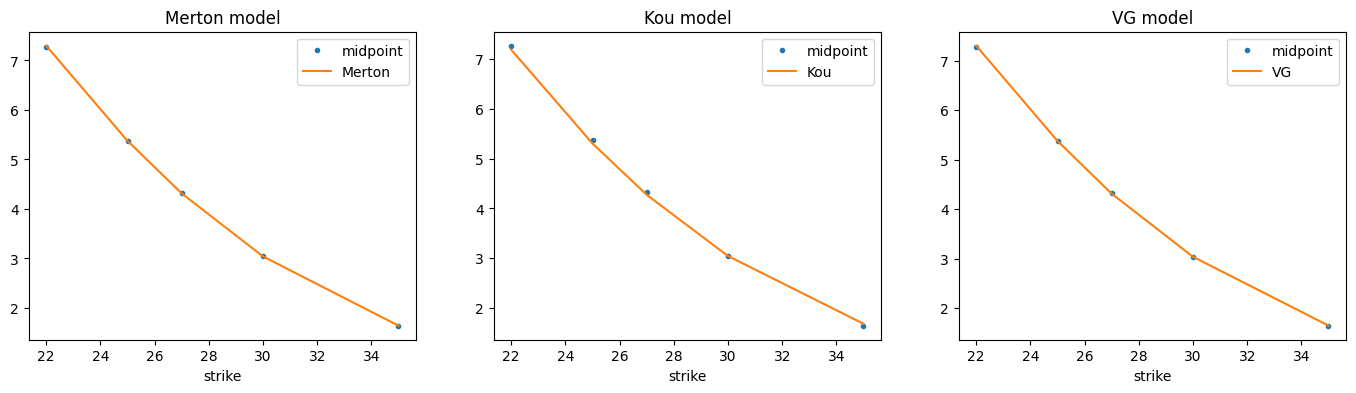

In [39]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, call_prices, ".", label="midpoint")
ax2.plot(call_strikes, call_prices, ".", label="midpoint")
ax3.plot(call_strikes, call_prices, ".", label="midpoint")
ax1.plot(call_strikes, merton_cf_prices, label="Merton")
ax2.plot(call_strikes, kou_cf_prices, label="Kou")
ax3.plot(call_strikes, vg_cf_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

#### Monte Carlo option pricing

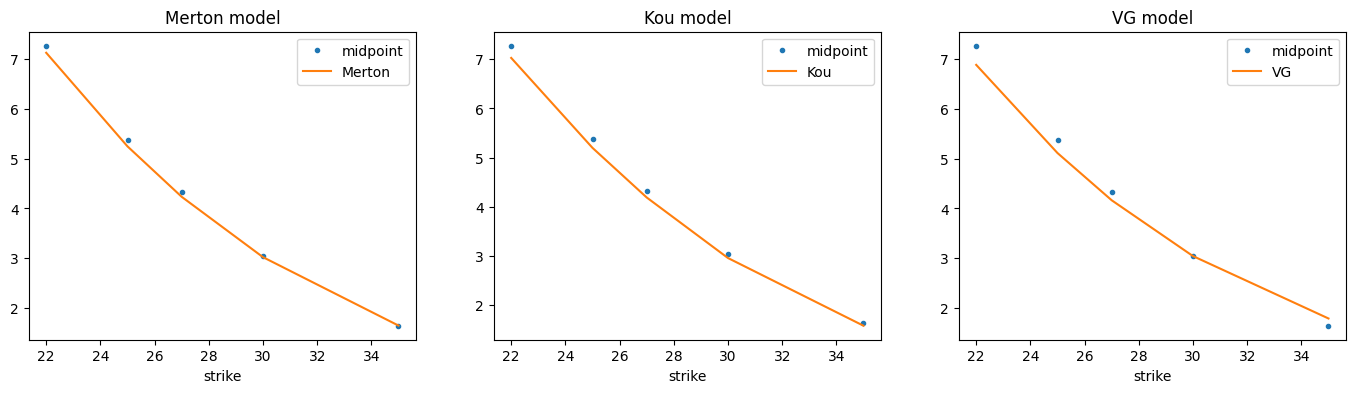

In [40]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, call_prices, ".", label="midpoint")
ax2.plot(call_strikes, call_prices, ".", label="midpoint")
ax3.plot(call_strikes, call_prices, ".", label="midpoint")
ax1.plot(call_strikes, merton_mc_prices, label="Merton")
ax2.plot(call_strikes, kou_mc_prices, label="Kou")
ax3.plot(call_strikes, vg_mc_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()